# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

44596


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':[r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304',
                            r'\\10.245.74.212\Chromatin_NAS_2\20220316-P_brain_CTP11-12-13_from_0304'],
             'save_folder':r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304',
             'experiment_type': 'DNA',
             'num_threads': 32,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


168 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder


In [15]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [4]:
save_fov_ids = save_fov_ids[:115]
save_filenames = save_filenames[:115]

# 2. Translate segmentation

## 2.1 load rotation matrix

In [5]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220304-P_brain_M1_nonclear_adaptors\CellPoseSegment\features'
merfish_dapi_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation_Cellpose'
if not os.path.exists(merfish_dapi_folder):
    os.makedirs(merfish_dapi_folder)
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'][0], 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99997433 -0.00716481]
 [ 0.00716481  0.99997433]],
 translation:[-238.54348979 -722.53301093]
-- rotation matrix saved to file:\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\translation


## 2.2 save DAPI image for RNA

In [6]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [7]:
overwrite_dapi = False
for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _im = ia.visual_tools.DaxReader(os.path.join(ref_fd, rna_fovs[_fov_id])).loadAll()
        _dapi_im = _im[4::5]
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 677.44it/s]


## 2.3 Prepare args

In [8]:
import multiprocessing as mp
# savefile for segmentations
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [9]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
_segmentation_savefile_lock = _manager.RLock()
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))

    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, microscope_file, R, 
             _total_seg_save_file, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

115
Wall time: 207 ms


## 2.4 test run and plot

In [11]:
import ImageAnalysis3.segmentation_tools.cell
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[0][2],_seg_align_args[0][3],_seg_align_args[0][4],
    microscope_file, R,   debug=True, 
)

_dna_mask, _full_rna_mask, _rna_dapi, _rot_rna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[0][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [  0.1  18.8 -65.2] in 1.547s.
-- drift 1: [  0.   26.2 -72.7] in 1.531s.
-- drift 2: [ -0.1  25.7 -70.9] in 1.485s.
-- drift 3: [  0.   23.2 -77.3] in 1.555s.
-- drift 4: [  0.   18.8 -68.4] in 1.462s.
-- drift 5: [  0.   23.4 -69.7] in 1.549s.
-- drift 6: [  0.   27.6 -70.2] in 1.494s.
-- drift 7: [  0.   24.7 -75.6] in 1.537s.
-- return a sub-optimal drift
--- drift: [-3.000e-02  2.650e+01 -7.127e+01] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


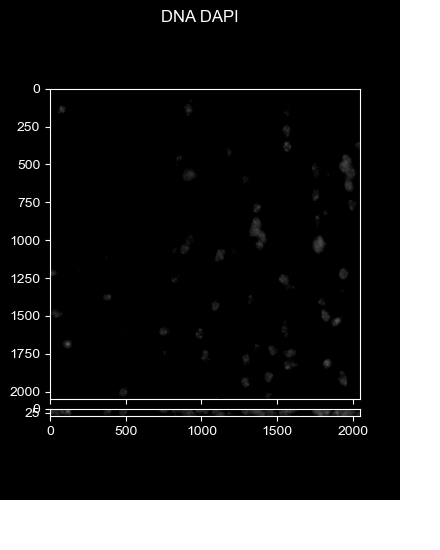

In [12]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi], min_max_default=[10000,50000], image_names=['DNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

<IPython.core.display.Javascript object>


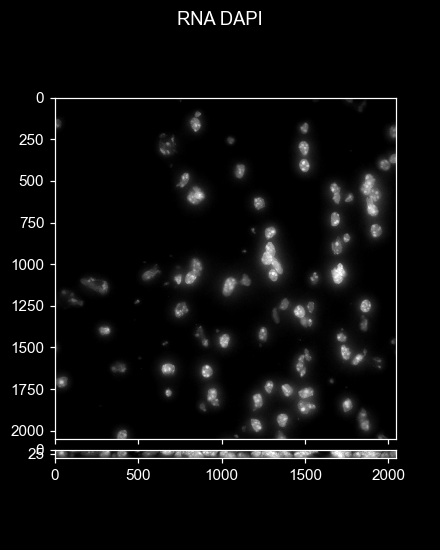

In [13]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_rna_dapi], min_max_default=[500,8000], image_names=['RNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_rna_dapi.png'), transparent=True)

## 2.5 batch run translation

In [10]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(16) as _seg_pool:
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 417.439s. 
Wall time: 7min 9s


# 3 Partition DNA-MERFISH spots

In [11]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [12]:
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
import ImageAnalysis3.io_tools.spots 
reload(segmentation_tools.cell)
reload(io_tools.spots)
reload(ia.classes.preprocess)
reload(ia.classes.partition_spots)

<module 'ImageAnalysis3.classes.partition_spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\partition_spots.py'>

## 3.1 prepare spots for partition


In [13]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = True

#_total_seg_save_file defined in 2.3
_partition_args = []

In [16]:
%%time
for _fov_id, _save_filename in zip(save_fov_ids[-1:], save_filenames[-1:]):
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_total_seg_save_file)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, 'combo', None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, 'relabeled_combo', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, 60, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:114 into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Segmentation\full_segmentation.hdf5
1
Wall time: 15.7 s


In [17]:
%%time
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(16) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 232.900s. 
Wall time: 3min 52s


# 3. Decoding of DNA-MERFISH

In [18]:
# load two codebooks
import pandas as pd
codebook_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
codebook_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
codebook_se['id'] = codebook_se['id'] + np.max(codebook_gn['id'])

### re-sort chr_order

In [19]:
# combine region_ids
merged_codebook = pd.concat([codebook_gn, codebook_se], axis=0, join='outer',ignore_index=True).fillna(0)

merged_codebook['reg_start'] = [int(_name.split(':')[1].split('-')[0]) for _name in merged_codebook['name']]
merged_codebook['reg_end'] = [int(_name.split(':')[1].split('-')[1]) for _name in merged_codebook['name']]
merged_codebook['reg_mid'] = (merged_codebook['reg_start'] + merged_codebook['reg_end'])/2

for _chr in np.unique(merged_codebook['chr']):
    _chr_codebook = merged_codebook[merged_codebook['chr']==_chr]
    _reg_order = np.argsort(merged_codebook.loc[merged_codebook['chr']==_chr, 'reg_mid'])
    merged_codebook.loc[_chr_codebook.index[_reg_order], 'chr_order'] = np.arange(len(_chr_codebook))
    
# cleanup 
codebook_df = merged_codebook[[_c for _c in merged_codebook.columns if 'reg_' not in _c]]

In [20]:
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
codebook_df.to_csv(os.path.join(decoder_folder, 'merged_codebook.csv'), index=False)

## 3.2 load spot files

In [22]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [23]:
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [25]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
return_decoder = False
skip_exist = True
load_exist = False

pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        if os.path.exists(_decoder_filename) and skip_exist:
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, combo_ids,
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 load_exist, overwrite_decoder, return_decoder, False) 
        # append
        decode_args.append(_args)
    
print(len(decode_args))

- Preparing decoding args for fov: 0
- Preparing decoding args for fov: 1
- Preparing decoding args for fov: 2
- Preparing decoding args for fov: 3
- Preparing decoding args for fov: 4
- Preparing decoding args for fov: 5
- Preparing decoding args for fov: 6
- Preparing decoding args for fov: 7
- Preparing decoding args for fov: 8
- Preparing decoding args for fov: 9
- Preparing decoding args for fov: 10
- Preparing decoding args for fov: 11
- Preparing decoding args for fov: 12
- Preparing decoding args for fov: 13
- Preparing decoding args for fov: 14
- Preparing decoding args for fov: 15
- Preparing decoding args for fov: 16
- Preparing decoding args for fov: 17
- Preparing decoding args for fov: 18
- Preparing decoding args for fov: 19
- Preparing decoding args for fov: 20
- Preparing decoding args for fov: 21
- Preparing decoding args for fov: 22
- Preparing decoding args for fov: 23
- Preparing decoding args for fov: 24
- Preparing decoding args for fov: 25
- Preparing decoding a

In [35]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 300
decoder = decode.batch_decode_DNA(*decode_args[_cell_ind])

Creating DNA_Merfish_Decoder class.
- 21181 pairs kept given search radius 300 nm.
-- search spot_groups given search radius 300 nm, max_usage=1


100%|█████████████████████████████████████████████████████████████████████| 21181/21181 [00:00<00:00, 136841.29it/s]


- 4709 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_Decoder.hdf5
-- save cand_spots into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_Decoder.hdf5
-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_Decoder.hdf5


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'start', 'end',
       'chr'],
      dtype='object')]

  pytables.to_hdf(


-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_Decoder.hdf5
-- seeding chr:1 with 153 regions with 392 spot_groups
-- init 2 homologs for chr:1
- diff in iter-0: 0.5077
- diff in iter-1: 0.0204
- diff in iter-2: 0.0000
-- seeding chr:10 with 115 regions with 216 spot_groups
-- init 2 homologs for chr:10
- diff in iter-0: 0.5185
- diff in iter-1: 0.1944
- diff in iter-2: 0.1620
- diff in iter-3: 0.0741
- diff in iter-4: 0.0231
- diff in iter-5: 0.0046
- diff in iter-6: 0.0046
- diff in iter-7: 0.0046
- diff in iter-8: 0.0046
- diff in iter-9: 0.0046
- diff in iter-10: 0.0046
- diff in iter-11: 0.0046
- diff in iter-12: 0.0046
- diff in iter-13: 0.0046
- diff in iter-14: 0.0046
- diff in iter-15: 0.0046
-- seeding chr:11 with 105 regions with 185 spot_groups
-- init 2 homologs for chr:11
- diff in iter-0: 0.4432
- diff in iter-1: 0.0270
- diff in iter-2: 0.0270
- diff in iter-3: 0.0703
- diff in iter-4: 0.1730
- diff i

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- diff in iter-0: 0.5312
- diff in iter-1: 0.0417
- diff in iter-2: 0.0000
-- seeding chr:Y with 1 regions with *3 spot_groups
- processing chr:1
- diff in iter-0: 0.4962
- diff in iter-1: 0.0000
- processing chr:10
- diff in iter-0: 0.6806
- diff in iter-1: 0.0185
- diff in iter-2: 0.0000
- processing chr:11
- diff in iter-0: 0.6162
- diff in iter-1: 0.0216
- diff in iter-2: 0.0216
- diff in iter-3: 0.0000
- processing chr:12
- diff in iter-0: 0.4679
- diff in iter-1: 0.0000
- processing chr:13
- diff in iter-0: 0.5786
- diff in iter-1: 0.0126
- diff in iter-2: 0.0000
- processing chr:14
- diff in iter-0: 0.5527
- diff in iter-1: 0.0109
- diff in iter-2: 0.0182
- diff in iter-3: 0.0073
- diff in iter-4: 0.0000
- processing chr:15
- diff in iter-0: 0.5330
- diff in iter-1: 0.0000
- processing chr:16
- diff in iter-0: 0.5249
- diff in iter-1: 0.0307
- diff in iter-2: 0.0000
- processing chr:17
- diff in iter-0: 0.5095
- diff in iter-1: 0.0238
- diff in iter-2: 0.0000
- processing chr:18

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel

-- save tuples for :chr_2_assigned_tuple_list/1/1
-- save tuples for :chr_2_assigned_tuple_list/10/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/10/1
-- save tuples for :chr_2_assigned_tuple_list/11/0
-- save tuples for :chr_2_assigned_tuple_list/11/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/12/0
-- save tuples for :chr_2_assigned_tuple_list/12/1
-- save tuples for :chr_2_assigned_tuple_list/13/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/13/1
-- save tuples for :chr_2_assigned_tuple_list/14/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  pytables.to_hdf(


-- save tuples for :chr_2_assigned_tuple_list/14/1
-- save tuples for :chr_2_assigned_tuple_list/15/0
-- save tuples for :chr_2_assigned_tuple_list/15/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/16/0
-- save tuples for :chr_2_assigned_tuple_list/16/1
-- save tuples for :chr_2_assigned_tuple_list/17/0
-- save tuples for :chr_2_assigned_tuple_list/17/1
-- save tuples for :chr_2_assigned_tuple_list/18/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/18/1
-- save tuples for :chr_2_assigned_tuple_list/19/0
-- save tuples for :chr_2_assigned_tuple_list/19/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/2/0
-- save tuples for :chr_2_assigned_tuple_list/2/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/3/0
-- save tuples for :chr_2_assigned_tuple_list/3/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/4/0
-- save tuples for :chr_2_assigned_tuple_list/4/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/5/0
-- save tuples for :chr_2_assigned_tuple_list/5/1
-- save tuples for :chr_2_assigned_tuple_list/6/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/6/1
-- save tuples for :chr_2_assigned_tuple_list/7/0


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/7/1
-- save tuples for :chr_2_assigned_tuple_list/8/0
-- save tuples for :chr_2_assigned_tuple_list/8/1
-- save tuples for :chr_2_assigned_tuple_list/9/0
-- save tuples for :chr_2_assigned_tuple_list/9/1


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


-- save tuples for :chr_2_assigned_tuple_list/X/0
- Update chr_2_indices_list into \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_Decoder.hdf5
-- saving 1 in chr_2_indices_list
-- saving 10 in chr_2_indices_list
-- saving 11 in chr_2_indices_list
-- saving 12 in chr_2_indices_list
-- saving 13 in chr_2_indices_list
-- saving 14 in chr_2_indices_list
-- saving 15 in chr_2_indices_list
-- saving 16 in chr_2_indices_list
-- saving 17 in chr_2_indices_list
-- saving 18 in chr_2_indices_list
-- saving 19 in chr_2_indices_list
-- saving 2 in chr_2_indices_list
-- saving 3 in chr_2_indices_list
-- saving 4 in chr_2_indices_list
-- saving 5 in chr_2_indices_list
-- saving 6 in chr_2_indices_list
-- saving 7 in chr_2_indices_list
-- saving 8 in chr_2_indices_list
-- saving 9 in chr_2_indices_list
-- saving X in chr_2_indices_list
- Update chr_2_zxys_list into \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-20_Cell-40_De

In [84]:
test_arg = list(decode_args[_cell_ind])
test_arg[16] = True
test_arg[18] = True
decoder = decode.batch_decode_DNA(*tuple(test_arg))

Creating DNA_Merfish_Decoder class.
- 22752 pairs kept given search radius 300 nm.
-- search spot_groups given search radius 300 nm, max_usage=1


100%|█████████████████████████████████████████████████████████████████████| 22752/22752 [00:00<00:00, 130771.68it/s]


- 4971 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-0_Cell-4_Decoder.hdf5
-- save cand_spots into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-0_Cell-4_Decoder.hdf5
-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-0_Cell-4_Decoder.hdf5


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'start', 'end',
       'chr'],
      dtype='object')]

  pytables.to_hdf(


-- save spot_groups into: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Fov-0_Cell-4_Decoder.hdf5
-- seeding chr:1 with 153 regions with 383 spot_groups
-- init 2 homologs for chr:1
- diff in iter-0: 0.4073
- diff in iter-1: 0.0470
- diff in iter-2: 0.0339
- diff in iter-3: 0.0209
- diff in iter-4: 0.0131
- diff in iter-5: 0.0104
- diff in iter-6: 0.0157
- diff in iter-7: 0.0522
- diff in iter-8: 0.1097
- diff in iter-9: 0.1358
- diff in iter-10: 0.1123
- diff in iter-11: 0.1253
- diff in iter-12: 0.1097
- diff in iter-13: 0.0705
- diff in iter-14: 0.0444
- diff in iter-15: 0.0078
-- seeding chr:10 with 115 regions with 294 spot_groups
-- init 2 homologs for chr:10
- diff in iter-0: 0.5068
- diff in iter-1: 0.0442
- diff in iter-2: 0.0476
- diff in iter-3: 0.0102
- diff in iter-4: 0.0000
-- seeding chr:11 with 105 regions with 300 spot_groups
-- init 2 homologs for chr:11
- diff in iter-0: 0.4500
- diff in iter-1: 0.0533
- diff in iter-2: 0.0067
- diff in 

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- diff in iter-0: 0.5111
- diff in iter-1: 0.0444
- diff in iter-2: 0.0111
- diff in iter-3: 0.0000
-- seeding chr:Y with 1 regions with *0 spot_groups
- processing chr:1
- diff in iter-0: 0.5196
- diff in iter-1: 0.0235
- diff in iter-2: 0.0052
- diff in iter-3: 0.0000
- processing chr:10
- diff in iter-0: 0.4949
- diff in iter-1: 0.0339
- diff in iter-2: 0.0034
- diff in iter-3: 0.0000
- processing chr:11
- diff in iter-0: 0.4500
- diff in iter-1: 0.0067
- diff in iter-2: 0.0000
- processing chr:12
- diff in iter-0: 0.5325
- diff in iter-1: 0.0216
- diff in iter-2: 0.0000
- processing chr:13
- diff in iter-0: 0.4821
- diff in iter-1: 0.0080
- diff in iter-2: 0.0080
- diff in iter-3: 0.0000
- processing chr:14
- diff in iter-0: 0.4871
- diff in iter-1: 0.0129
- diff in iter-2: 0.0043
- diff in iter-3: 0.0043
- diff in iter-4: 0.0000
- processing chr:15
- diff in iter-0: 0.4840
- diff in iter-1: 0.0091
- diff in iter-2: 0.0000
- processing chr:16
- diff in iter-0: 0.4686
- diff in iter

E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  pytables.to_hdf(
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to a

-- save tuples for :chr_2_assigned_tuple_list/1/1
-- save tuples for :chr_2_assigned_tuple_list/10/0
-- save tuples for :chr_2_assigned_tuple_list/10/1
-- save tuples for :chr_2_assigned_tuple_list/11/0
-- save tuples for :chr_2_assigned_tuple_list/11/1
-- save tuples for :chr_2_assigned_tuple_list/12/0
-- save tuples for :chr_2_assigned_tuple_list/12/1
-- save tuples for :chr_2_assigned_tuple_list/13/0
-- save tuples for :chr_2_assigned_tuple_list/13/1
-- save tuples for :chr_2_assigned_tuple_list/14/0
-- save tuples for :chr_2_assigned_tuple_list/14/1
-- save tuples for :chr_2_assigned_tuple_list/15/0
-- save tuples for :chr_2_assigned_tuple_list/15/1
-- save tuples for :chr_2_assigned_tuple_list/16/0
-- save tuples for :chr_2_assigned_tuple_list/16/1
-- save tuples for :chr_2_assigned_tuple_list/17/0
-- save tuples for :chr_2_assigned_tuple_list/17/1
-- save tuples for :chr_2_assigned_tuple_list/18/0
-- save tuples for :chr_2_assigned_tuple_list/18/1
-- save tuples for :chr_2_assign

## visualize decoded spots

In [24]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder
Use decode_figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder\Figures


<IPython.core.display.Javascript object>


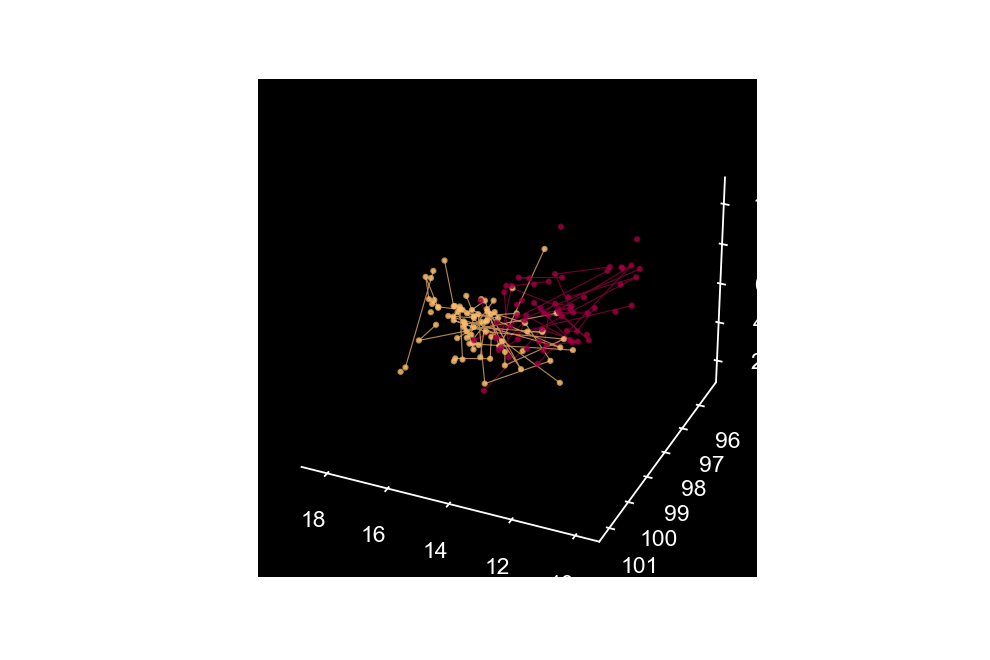

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [107]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_chr_name = '5'
_zxys_list = np.array(decoder.chr_2_zxys_list[_chr_name])/1000

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=30)
ani.save(os.path.join(decode_figure_folder, 
                      os.path.basename(decoder.savefile).replace('.hdf5', f'_Picked_chr-{_chr_name}.gif')), 
         writer=animation.PillowWriter(fps=30))

plt.show()

## 3.4 process all

In [ ]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(20) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

5261


In [39]:
pickle.load(open(r'X:\Chromatin_Libraries\CTP-12_mop_markers\marker_gene_TSS\gene_2_readout.pkl', 'rb'))

{'Slc30a3': ['u0', 'u0'],
 'Slc17a7': ['u1', 'u1'],
 'Slc32a1': ['u2', 'u2'],
 'Gad1': ['u3', 'u3'],
 'Otof': ['u4', 'u4'],
 'Rspo1': ['u5', 'u5'],
 'Pvalb': ['u6', 'u6'],
 'Sst': ['u7', 'u7'],
 'Vip': ['u8', 'u8'],
 'Sncg': ['u9', 'u9'],
 'Lamp5': ['u10', 'u10'],
 'Lratd2': ['u11', 'u11'],
 'Tshz2': ['u12', 'u12'],
 'Syt6': ['u13', 'u13'],
 'Nxph4': ['u14', 'u14'],
 'Cux2': ['u15', 'u15'],
 'Rorb': ['u16', 'u16'],
 'Sulf2': ['u17', 'u17'],
 'Ptpru': ['u18', 'u18'],
 'Car3': ['u19', 'u19'],
 'Aqp4': ['u20', 'u20'],
 'Flt1': ['u21', 'u21'],
 'Igf2': ['u22', 'u22'],
 'Pdgfra': ['u23', 'u23'],
 'Sox10': ['u24', 'u24'],
 'Ctss': ['u25', 'u25'],
 'Vtn': ['u26', 'u26'],
 'Bgn': ['u27', 'u27']}

In [40]:
pickle.load(open(r'X:\Chromatin_Libraries\CTP-12_mop_markers\marker_gene_TSS\readout_usage.pkl', 'rb'))

{'u': [SeqRecord(seq=Seq('TTCCCGCCAATGACGTCGGTTTGGACGAGA'), id='Stv_91', name='Stv_91', description='Stv_91 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('AGACGACGCACGTTCGTACCGCGTACTTCG'), id='Stv_32', name='Stv_32', description='Stv_32 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('GCGTTGATGTCCCTTGTGAGCGCCCGACAT'), id='Stv_92', name='Stv_92', description='Stv_92 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('TTTGCTCGCAAGTGCGCACGAGTTGAACTG'), id='Stv_33', name='Stv_33', description='Stv_33 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('CGCTTATCGATGTCAGGTCCGCATGGGTCG'), id='Stv_94', name='Stv_94', description='Stv_94 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('AGTTTCCATACGCGGCGTGAATATCGCGGC'), id='Stv_35', name='Stv_35', description='Stv_35 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('AACGTCATCGGTGGATCCCAGAGTGCCAAA'), id='Stv_95', name='Stv_95', description='Stv_95 old_barcode', dbxrefs=[]),
  SeqRecord(seq=Seq('GCTACAGCGTTACGGGCCCAGACGTTTCAT'), id='Stv_36', name='Stv_36', de

In [41]:
pickle.load(open(r'X:\Chromatin_Libraries\CTP-12_mop_markers\marker_gene_TSS\readout_summary.pkl', 'rb'))

{'u': {'Aqp4': [SeqRecord(seq=Seq('TTCCCACACGCCAAGCGCAGACGAACGGCA'), id='Stv_107', name='Stv_107', description='Stv_107 old_barcode', dbxrefs=[])],
  'Bgn': [SeqRecord(seq=Seq('ACACCCGATACGTCGTGGGACGTGGACCGT'), id='Stv_53', name='Stv_53', description='Stv_53 old_barcode', dbxrefs=[])],
  'Car3': [SeqRecord(seq=Seq('TAATTCCGGTATCGGGCCCTTTTGTCTGAC'), id='Stv_45', name='Stv_45', description='Stv_45 old_barcode', dbxrefs=[])],
  'Ctss': [SeqRecord(seq=Seq('GCCATGGTACGACGGCAAGAGAGCGTGCGT'), id='Stv_50', name='Stv_50', description='Stv_50 old_barcode', dbxrefs=[])],
  'Cux2': [SeqRecord(seq=Seq('GCGGGATTCGTACGAGCCCTCTTGGACGGG'), id='Stv_42', name='Stv_42', description='Stv_42 old_barcode', dbxrefs=[])],
  'Flt1': [SeqRecord(seq=Seq('CGTGAGAATGCGTCGCGATACTGGTGTAAG'), id='Stv_46', name='Stv_46', description='Stv_46 old_barcode', dbxrefs=[])],
  'Gad1': [SeqRecord(seq=Seq('TTTGCTCGCAAGTGCGCACGAGTTGAACTG'), id='Stv_33', name='Stv_33', description='Stv_33 old_barcode', dbxrefs=[])],
  'Igf2': [Se